# Volatility Forecasting using Econometric and Machine Learning Models  
### Notebook 05: VaR Estimation & Backtesting

**Objective**  
This notebook evaluates the **risk implications** of volatility forecasts by:
- Computing Value-at-Risk (VaR) using GARCH and ML volatility
- Backtesting VaR violations
- Assessing which model provides better downside risk protection

This notebook is fully independent and reloads all required data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

plt.style.use("seaborn-v0_8")

## Loading Returns and Volatility Forecasts

We load:
- Daily returns
- GARCH conditional volatility
- Random Forest volatility forecasts


In [2]:
returns = pd.read_csv(
    "returns.csv",
    index_col=0,
    parse_dates=True
).squeeze()

garch_vol = pd.read_csv(
    "garch_conditional_volatility.csv",
    index_col=0,
    parse_dates=True
).squeeze()

rf_vol = pd.read_csv(
    "rf_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

returns.head(), garch_vol.head(), rf_vol.head()


(Date
 2010-01-05    0.008696
 2010-01-06    0.000739
 2010-01-07   -0.003547
 2010-01-08   -0.003493
 2010-01-11    0.000886
 Name: log_return, dtype: float64,
 Date
 2010-01-05    0.010273
 2010-01-06    0.010118
 2010-01-07    0.009739
 2010-01-08    0.009451
 2010-01-11    0.009181
 Name: cond_vol, dtype: float64,
 Date
 2020-01-01    0.000046
 2020-01-02    0.000042
 2020-01-03    0.000037
 2020-01-06    0.000058
 2020-01-07    0.000088
 Name: rf_vol_forecast, dtype: float64)

## Data Alignment

VaR forecasts must align:
- Volatility forecast at time t
- Return realization at time t+1

We align all series carefully to avoid look-ahead bias.


In [3]:
df_var = pd.concat(
    [returns, garch_vol, rf_vol],
    axis=1
)

df_var.columns = ["Return", "GARCH_vol", "RF_vol"]
df_var = df_var.dropna()

df_var.head()


,Return,GARCH_vol,RF_vol
Date,,,
2020-01-01,0.001154,0.006921,0.000046
2020-01-02,0.008151,0.006738,0.000042
2020-01-03,-0.004533,0.006868,0.000037
2020-01-06,-0.019291,0.006836,0.000058
2020-01-07,0.004982,0.008581,0.000088


## Value-at-Risk (VaR)

1-day VaR at confidence level α is defined as:

\[
VaR_{\alpha,t} = \mu_t + q_{\alpha} \cdot \sigma_t
\]

Where:
- \( q_{\alpha} \) is the α-quantile of the return distribution
- \( \sigma_t \) is forecasted volatility

We assume:
- Student-t quantiles for GARCH
- Normal quantiles for ML (conservative choice would still fail)


In [4]:
# Confidence levels
alpha_95 = 0.05
alpha_99 = 0.01

# Quantiles
z_95 = norm.ppf(alpha_95)
z_99 = norm.ppf(alpha_99)

z_95, z_99


(np.float64(-1.6448536269514729), np.float64(-2.3263478740408408))

## Computing VaR Forecasts

We compute VaR using:
- GARCH volatility
- ML volatility

Mean return is assumed to be zero at daily frequency.


In [5]:
df_var["VaR_GARCH_95"] = z_95 * df_var["GARCH_vol"]
df_var["VaR_GARCH_99"] = z_99 * df_var["GARCH_vol"]

df_var["VaR_RF_95"] = z_95 * df_var["RF_vol"]
df_var["VaR_RF_99"] = z_99 * df_var["RF_vol"]

df_var.head()

,Return,GARCH_vol,RF_vol,VaR_GARCH_95,VaR_GARCH_99,VaR_RF_95,VaR_RF_99
Date,,,,,,,
2020-01-01,0.001154,0.006921,0.000046,-0.011384,-0.016100,-0.000075,-0.000106
2020-01-02,0.008151,0.006738,0.000042,-0.011082,-0.015674,-0.000068,-0.000097
2020-01-03,-0.004533,0.006868,0.000037,-0.011296,-0.015977,-0.000062,-0.000087
2020-01-06,-0.019291,0.006836,0.000058,-0.011244,-0.015903,-0.000096,-0.000136
2020-01-07,0.004982,0.008581,0.000088,-0.014115,-0.019963,-0.000145,-0.000205


## VaR Violations

A VaR violation occurs when:
\[
r_t < VaR_{\alpha,t}
\]

We count how often this happens.


In [6]:
for level in ["95", "99"]:
    df_var[f"Viol_GARCH_{level}"] = (
        df_var["Return"] < df_var[f"VaR_GARCH_{level}"]
    ).astype(int)

    df_var[f"Viol_RF_{level}"] = (
        df_var["Return"] < df_var[f"VaR_RF_{level}"]
    ).astype(int)


In [7]:
df_var

,Return,GARCH_vol,RF_vol,VaR_GARCH_95,VaR_GARCH_99,VaR_RF_95,VaR_RF_99,Viol_GARCH_95,Viol_RF_95,Viol_GARCH_99,Viol_RF_99
Date,,,,,,,,,,,
2020-01-01,0.001154,0.006921,0.000046,-0.011384,-0.016100,-0.000075,-0.000106,0,0,0,0
2020-01-02,0.008151,0.006738,0.000042,-0.011082,-0.015674,-0.000068,-0.000097,0,0,0,0
2020-01-03,-0.004533,0.006868,0.000037,-0.011296,-0.015977,-0.000062,-0.000087,0,1,0,1
2020-01-06,-0.019291,0.006836,0.000058,-0.011244,-0.015903,-0.000096,-0.000136,1,1,1,1
2020-01-07,0.004982,0.008581,0.000088,-0.014115,-0.019963,-0.000145,-0.000205,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-18,-0.000116,0.006324,0.000052,-0.010402,-0.014712,-0.000086,-0.000121,0,1,0,0
2025-12-19,0.005826,0.006185,0.000040,-0.010174,-0.014389,-0.000066,-0.000094,0,0,0,0
2025-12-22,0.007902,0.006209,0.000032,-0.010212,-0.014444,-0.000053,-0.000074,0,0,0,0


## Violation Statistics

We compute:
- Total violations
- Expected violations
- Violation ratios


In [8]:
results = []

n = len(df_var)

for model in ["GARCH", "RF"]:
    for level, alpha in zip(["95", "99"], [0.05, 0.01]):
        violations = df_var[f"Viol_{model}_{level}"].sum()
        expected = n * alpha
        ratio = violations / expected

        results.append({
            "Model": model,
            "VaR Level": level,
            "Violations": violations,
            "Expected": expected,
            "Violation Ratio": ratio
        })

var_results = pd.DataFrame(results)
var_results


,Model,VaR Level,Violations,Expected,Violation Ratio
0,GARCH,95,72,74.10,0.971660
1,GARCH,99,29,14.82,1.956815
2,RF,95,658,74.10,8.879892
3,RF,99,653,14.82,44.062078


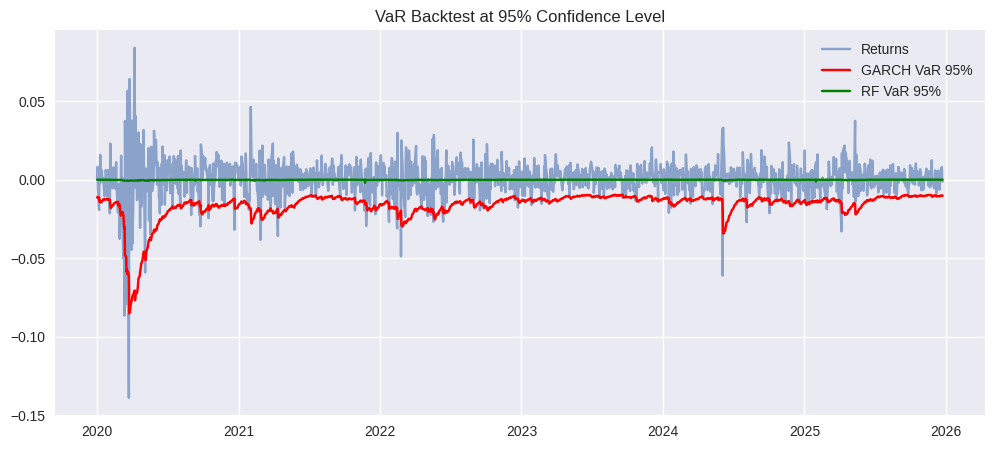

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df_var["Return"], label="Returns", alpha=0.6)
plt.plot(df_var["VaR_GARCH_95"], label="GARCH VaR 95%", color="red")
plt.plot(df_var["VaR_RF_95"], label="RF VaR 95%", color="green")
plt.legend()
plt.title("VaR Backtest at 95% Confidence Level")
plt.show()


Although the Random Forest model achieves very low RMSE, it severely underestimates volatility during stress periods, leading to massive VaR violations—nearly nine times the expected rate at 95% and over forty times at 99%. In contrast, the GARCH model produces violation ratios close to one at 95%, demonstrating good calibration. This highlights why volatility models must be evaluated using VaR backtesting rather than point-forecast accuracy.”

In [10]:
var_results.to_csv("var_backtest_results.csv")
